# Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

# References

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/ <br>
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 <br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

## Imports

In [1]:
# for image name
import random

# define and move to dataset and model directory
import os
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/user/Desktop/Model"

# duplicate combined image to other directory and delete directory with its content
import shutil

#for stopping code if not the right amount of images
import sys

#histograph/confusion matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

#model creation
import tensorflow.keras as keras

import numpy as np

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#k-fold cross validation
import pandas as pd                                     #store all images and their class/label
from sklearn.model_selection import StratifiedKFold     
from sklearn.model_selection import train_test_split    #split the dataset to train-test
import tensorflow as tf                                 #for callbacks

#for model evaluation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score
from scipy import interp                            #interpolation needed for plotting all classes into one roc plot
from itertools import cycle                         #for the color of lines on that multiclass plot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#validating misclassified images
import cv2     #load the image

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [2]:
totaldsdirect = directory + "/CombinedTwoAngleEggs"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [3]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
1,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
2,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
3,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
4,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
...,...,...
595,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
596,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
597,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
598,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2


Classes: <br>
0 - Balut/Penoy <br> 
1 - Salted <br>
2 - Table

In [4]:
print(df['label'].unique())

['0' '1' '2']


Check if there are null values

In [5]:
print(df.isna().any())

filename    False
label       False
dtype: bool


## Split Data to train and test set

We will need to split the dataset to train and test set. Only the train set will be used for transfer learning with K-fold validation. Test set will be used for model prediction and use that for model evaluation. Stratify is used in order to split the data in equal numbers under the classes specified.

In [6]:
# Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=69)

Save the split sets to train and test set folders.

In [7]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copiedb

C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [8]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

,filename,label
91,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
156,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
95,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
130,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
83,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
...,...,...
466,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
552,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
576,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
268,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1


## Data Augmentation

We will apply data augmentation of the dataset per epoch in order to increase the accuracy of the models

In [9]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
    )

## Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [10]:
def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

## Save Models

K-fold cross validation will be used in training the model.The set of models produced per fold will be saved in an automatic generated folder. Every training will generated another folder to save the new set of models.

In [11]:
def savemodel():
    save_cur = ""  #check if there is any saved_models folders

    svnum = 0
    svnum2 = 0

    for x in os.listdir(gen_dir):
        if "saved_models" in x:
            save_cur = x
            if not save_cur == "":
                for word in save_cur.split("_"):
                    if word.isdigit():
                        svnum2 = int(word)
                        if svnum < svnum2:
                            svnum = svnum2


    #save_dir is where the created models using the current set of parameters are added        
    if save_cur == "":
        save_dir = gen_dir + "/saved_models_1"
        os.makedirs(save_dir)
    else:
        save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
        os.makedirs(save_dir)
        
    return save_dir

###### Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [12]:
def model():
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    predictions = keras.layers.Dense(3, activation='softmax')(x)
    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    return full_model

In [13]:
full_model = model()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
stopper

NameError: name 'stopper' is not defined

## Hyper-Parameter Tuning

We will check the parameters that yielded the best results. A set of values on chosen parameters is given. The one that will yield the best results will be used for prediction.

### Model Parameters

In [15]:
#kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

#initialize parameters
VALIDATION_ACCURACY = []                          #holds all validation_accuracy
VALIDATION_LOSS = []                              #holds all validation_loss
image_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored
batch_size_arr = [8]                              #batch size
fold_var = 1                                      #number of fold of the model
n = len(df2)                                      #number of data in train set
num_epochs_arr = [5]                              #number of epochs
dim = (224,224)                                   #required dimensions for process_unit (ResNet50)
lr_arr = [0.0001]                                 #learning rate Adamax

param_arr = []                                    #holds the parameter values per combination
val_acc_arr = []                                  #holds the set of validation accuracy per combination
val_loss_arr = []                                 #holds the set of validation loss per combination
val_acc_means = []                                #holds the means of all set of validation loss per combination
val_loss_means = []                               #holds the means of all set of validation loss per combination

Train the model per combination of parameters.

Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Fold number 1
Epoch 1/5
54/54 [==============================] - 15s 184ms/step - loss: 1.0799 - accuracy: 0.4884 - val_loss: 0.9980 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
54/54 [==============================] - 7s 124ms/step - loss: 0.9226 - accuracy: 0.5579 - val_loss: 0.8614 - val_accuracy: 0.6481

Epoch 00002: val_accuracy improved from 0.50000 to 0.64815, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 3/5
54/54 [==============================] - 6s 116ms/step - loss: 0.8372 - accuracy: 0.6204 - val_loss: 0.8021 - val_accuracy: 0.6852

Epoch 00003: val_accuracy improved from 0.64815 to 0.68519, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 4/5
54/54 [==============================] - 7s 130ms/step - loss: 0.7865 - accuracy: 0.6644 - val_loss: 0.7399 - val_accuracy: 0.7130

Epoch 00004: val_accuracy improved from 0.68519 to 0.71296, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 5/5
54/54 [==============================] - 7s 125ms/step - loss: 0.7817 - accuracy: 0.6528 - val_loss: 0.6958 - val_accuracy: 0.7037

Epoch 00005: val_accuracy did not improve 

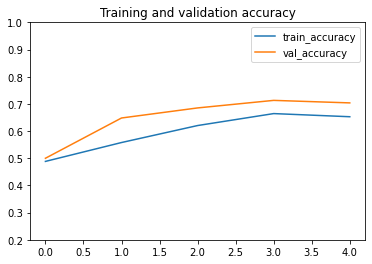

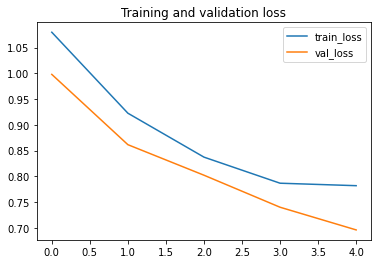

14/14 [==============================] - 2s 105ms/step - loss: 0.7752 - accuracy: 0.6481
{'loss': 0.7751606106758118, 'accuracy': 0.6481481194496155}
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Fold number 2
Epoch 1/5
54/54 [==============================] - 12s 142ms/step - loss: 1.0078 - accuracy: 0.5255 - val_loss: 1.2162 - val_accuracy: 0.3611

Epoch 00001: val_accuracy improved from -inf to 0.36111, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 2/5
54/54 [==============================] - 7s 137ms/step - loss: 0.8363 - accuracy: 0.6273 - val_loss: 1.0502 - val_accuracy: 0.4722

Epoch 00002: val_accuracy improved from 0.36111 to 0.47222, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 3/5
54/54 [==============================] - 7s 123ms/step - loss: 0.8095 - accuracy: 0.6204 - val_loss: 0.8982 - val_accuracy: 0.5741

Epoch 00003: val_accuracy improv

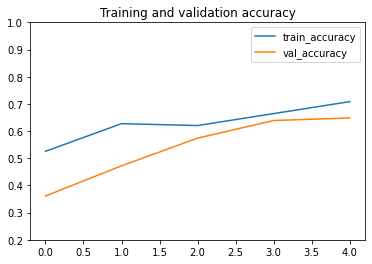

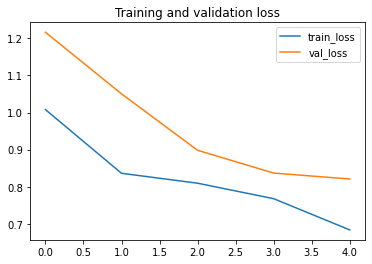

14/14 [==============================] - 2s 101ms/step - loss: 0.7565 - accuracy: 0.64811s - loss: 0.6101 - accuracy:  - ETA: 0s - loss: 0.6996 
{'loss': 0.7565028071403503, 'accuracy': 0.6481481194496155}
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Fold number 3
Epoch 1/5
54/54 [==============================] - 11s 145ms/step - loss: 1.0027 - accuracy: 0.4977 - val_loss: 1.0679 - val_accuracy: 0.4630

Epoch 00001: val_accuracy improved from -inf to 0.46296, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 2/5
54/54 [==============================] - 7s 134ms/step - loss: 0.8757 - accuracy: 0.5880 - val_loss: 0.9458 - val_accuracy: 0.5278

Epoch 00002: val_accuracy improved from 0.46296 to 0.52778, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 3/5
54/54 [==============================] - 7s 126ms/step - loss: 0.8231 - accuracy: 0.6250 - val_loss: 0.8386 

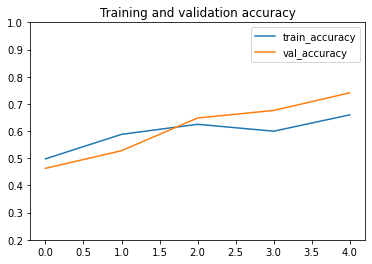

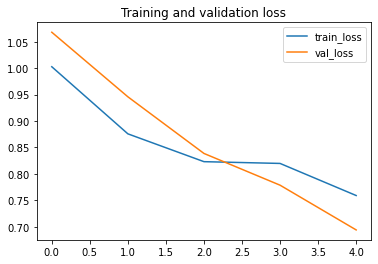

14/14 [==============================] - 2s 98ms/step - loss: 0.7342 - accuracy: 0.6574
{'loss': 0.7342323660850525, 'accuracy': 0.6574074029922485}
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Fold number 4
Epoch 1/5
54/54 [==============================] - 12s 164ms/step - loss: 0.9923 - accuracy: 0.5324 - val_loss: 0.9963 - val_accuracy: 0.5278

Epoch 00001: val_accuracy improved from -inf to 0.52778, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 2/5
54/54 [==============================] - 9s 158ms/step - loss: 0.8379 - accuracy: 0.6366 - val_loss: 0.9128 - val_accuracy: 0.6389

Epoch 00002: val_accuracy improved from 0.52778 to 0.63889, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 3/5
54/54 [==============================] - 8s 152ms/step - loss: 0.8032 - accuracy: 0.6181 - val_loss: 0.8200 - val_accuracy: 0.6481

Epoch 00003: val_accuracy improve

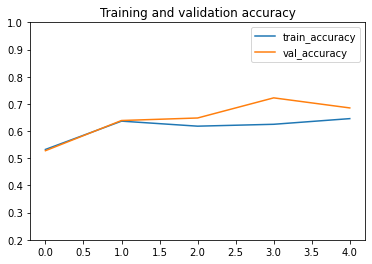

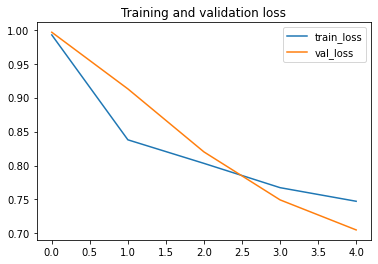

14/14 [==============================] - 2s 125ms/step - loss: 0.7361 - accuracy: 0.7593
{'loss': 0.7361041307449341, 'accuracy': 0.7592592835426331}
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Fold number 5
Epoch 1/5
54/54 [==============================] - 12s 165ms/step - loss: 1.0559 - accuracy: 0.4745 - val_loss: 1.0112 - val_accuracy: 0.5370

Epoch 00001: val_accuracy improved from -inf to 0.53704, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 2/5
54/54 [==============================] - 7s 132ms/step - loss: 0.8890 - accuracy: 0.5694 - val_loss: 0.9154 - val_accuracy: 0.6296

Epoch 00002: val_accuracy improved from 0.53704 to 0.62963, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 3/5
54/54 [==============================] - 8s 148ms/step - loss: 0.8259 - accuracy: 0.6227 - val_loss: 0.8368 - val_accuracy: 0.6389

Epoch 00003: val_accuracy improv

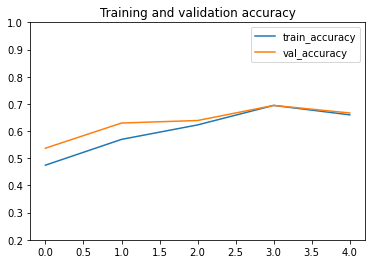

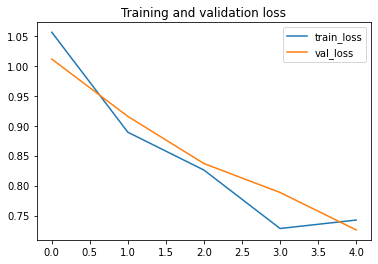

14/14 [==============================] - 2s 98ms/step - loss: 0.7804 - accuracy: 0.6759
{'loss': 0.7803669571876526, 'accuracy': 0.6759259104728699}


In [16]:
for x in range(len(batch_size_arr)):
    #for batch size values
    if len(param_arr) == 0:
        param_arr.append([])
    
    for y in range(len(num_epochs_arr)):
        #for epoch values
        if len(param_arr) == 1:
            param_arr.append([])
        
        for z in range(len(lr_arr)):
            #for learning rate values
            if len(param_arr) == 2:
                param_arr.append([])
            
            #append the values per combo
            param_arr[0].append(batch_size_arr[x])
            param_arr[1].append(num_epochs_arr[y])
            param_arr[2].append(lr_arr[z])
            
            VALIDATION_ACCURACY = []
            VALIDATION_LOSS = []
            
            #change save_dir value per combination
            save_dir = savemodel()
            fold_var = 1
            
            for train_index, val_index in skf.split(np.zeros(n),Y):

                training_data = df2.iloc[train_index]
                validation_data = df2.iloc[val_index]

                train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = image_dir,
                                           x_col = "filename", y_col = "label",
                                          class_mode = "categorical", target_size = dim, batch_size = batch_size_arr[x],
                                            shuffle = True)
                valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = image_dir,
                                        x_col = "filename", y_col = "label",
                                        class_mode = "categorical", target_size = dim, batch_size = batch_size_arr[x],
                                            shuffle = True)
                
                full_model = model()
                # Compile the model
                full_model.compile(loss='categorical_crossentropy',
                              optimizer=keras.optimizers.Adamax(learning_rate=lr_arr[z]),
                              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

                # Create callbacks
                checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                                        monitor='val_accuracy', verbose=1, 
                                        save_best_only=True, mode='max')
                callbacks_list = [checkpoint]
                # This saves the best model

                print("Fold number " + str(fold_var))

                # Fit the model
                history = full_model.fit(train_data_generator,
                                         epochs=num_epochs_arr[y],
                                         callbacks=callbacks_list,
                                         validation_data=valid_data_generator)

                #Plot the history
                plot_history(history, yrange=(0.2,1))

                # Load the best model instance to evaluate the performance of the model
                full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")

                results = full_model.evaluate(valid_data_generator)
                results = dict(zip(full_model.metrics_names,results))

                print(results)

                VALIDATION_ACCURACY.append(results['accuracy'])
                VALIDATION_LOSS.append(results['loss'])

                tf.keras.backend.clear_session()

                fold_var += 1
                
            val_acc_arr.append(VALIDATION_ACCURACY)
            val_loss_arr.append(VALIDATION_LOSS)

In [17]:
#append means of accuracy and loss sets per combo
for x in range(len(val_acc_arr)):
    val_acc_means.append(np.mean(val_acc_arr[x]))                                
    val_loss_means.append(np.mean(val_loss_arr[x]))

### Display Values Per Combination of Parameters

We will put the combination of parameters and the resulting means of accuracy and loss together in a dataframe in order to display it nicely.

In [18]:
df_hyperparam = pd.DataFrame(list(zip(param_arr[0],param_arr[1],param_arr[2],val_acc_means,val_loss_means))
                             ,columns=['batch size','number of epoch', 'learning rate', 'accuracy', 'loss'])

df_hyperparam

,batch size,number of epoch,learning rate,accuracy,loss
0,8,5,0.0001,0.677778,0.756473


### Best Accuracy

The combination that yielded the best results is then picked.

In [19]:
df_hyperparam.loc[df_hyperparam['accuracy'] == max(df_hyperparam['accuracy'])]

,batch size,number of epoch,learning rate,accuracy,loss
0,8,5,0.0001,0.677778,0.756473


In [20]:
stopper

NameError: name 'stopper' is not defined

## Kfold Evaluation Results

Below are the validation accuracy and validation loss per fold and their average of the best combination.

In [24]:
print("Validation Accuracy of All Folds:")
n = 1
for x in val_acc_arr[0]:
    print("Fold "+ str(n) +" Accuracy:",x)
    n=n+1    
print("Mean Validation Accuracy: " + str(np.mean(val_acc_arr[0])))

print("")

print("Validation Loss of All Folds:")
n=1
for x in val_loss_arr[0]:
    print("Fold "+ str(n) +" Loss:",x)
    n=n+1    
print("Mean Validation Loss: " + str(np.mean(val_loss_arr[0])))

Validation Accuracy of All Folds:
Fold 1 Accuracy: 0.6481481194496155
Fold 2 Accuracy: 0.6481481194496155
Fold 3 Accuracy: 0.6574074029922485
Fold 4 Accuracy: 0.7592592835426331
Fold 5 Accuracy: 0.6759259104728699
Mean Validation Accuracy: 0.6777777671813965

Validation Loss of All Folds:
Fold 1 Loss: 0.7751606106758118
Fold 2 Loss: 0.7565028071403503
Fold 3 Loss: 0.7342323660850525
Fold 4 Loss: 0.7361041307449341
Fold 5 Loss: 0.7803669571876526
Mean Validation Loss: 0.7564733743667602


In [25]:
stopper

NameError: name 'stopper' is not defined

## Model Prediction and Evaluation

Load the images in the test set and predict what class it is in all models of the best combination. There are three values of confidence level. The one with the highest confidence level is the predicted class of the image. The order of classes is [0 1 2]. The results will be feed to the eval function defined below in order to get the metrics.

In [26]:
#make the labels to integer to get the model metrics
yt = pd.to_numeric(y_test['label'])

The content displayed are the metrics, roc auc of each class (balut/penoy,salted,table), and confusion matrix per fold, as well as the sum and mean of those confusion matrices and roc auc of each class for all folds.

In [27]:
#Metrics
def evaluate(yhat_probs, 
             yhat_classes, 
             total_acc, 
             total_precision, 
             total_recall, 
             total_f1_score, 
             matrix_sum,
             fold_num,
             fpr_total,
             tpr_total):

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(yt, yhat_classes)
    total_acc.append(accuracy)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(yt, yhat_classes, average="weighted")
    total_precision.append(precision)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(yt, yhat_classes, average="weighted")
    total_recall.append(recall)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(yt, yhat_classes, average="weighted")
    total_f1_score.append(f1)
    print('F1 score: %f' % f1)
    
    #ROC AUC
    #-------------------------------------------------------------------------------
    # Binarize the true label
    ytbin = label_binarize(yt, classes=[0, 1, 2])
    n_classes = ytbin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
      
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytbin[:, i], yhat_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
     
        if fold_num == 0:
            fpr_total.append([])

        fpr_total[i].append(fpr[i])
        
        if fold_num == 0:
            tpr_total.append([])

        tpr_total[i].append(tpr[i]) 

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(ytbin.ravel(), yhat_probs.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    #balut-penoy
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Balut-Penoy Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()

    #salted egg
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Salted Egg Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()

    #table egg
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Table Egg Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()
    #-------------------------------------------------------------------------------
    
    #confusion matrix
    matrix = confusion_matrix(yt, yhat_classes)
    
    if len(total_acc) == 1:
        matrix_sum = matrix
    elif len(total_acc) > 1:
        matrix_sum = [[matrix_sum[i][j] + matrix[i][j]  
                       for j in range(len(matrix_sum[0]))] 
                      for i in range(len(matrix_sum))]
    
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[1]))
    df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                         index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})
    
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title('Confusion Matrix Fold ' + str(fold_num+1))
    plt.show()
    
    return total_acc, total_precision, total_recall, total_f1_score, matrix_sum, fpr_total, tpr_total

fold 1 metrics:
Accuracy: 0.616667
Precision: 0.613757
Recall: 0.616667
F1 score: 0.614463


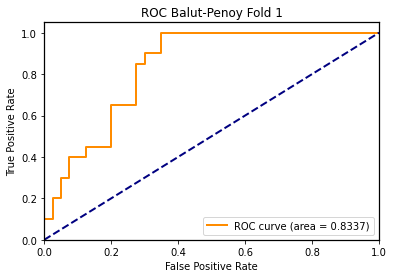

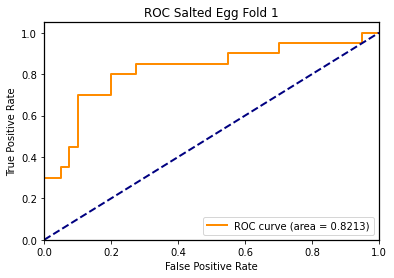

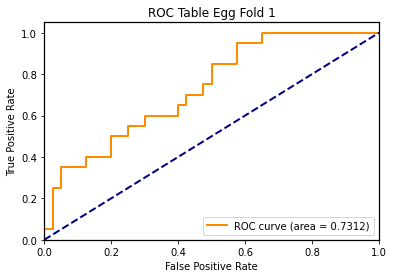

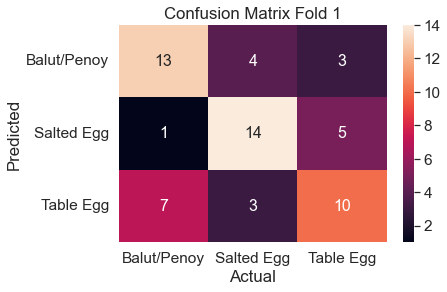


fold 2 metrics:
Accuracy: 0.650000
Precision: 0.653704
Recall: 0.650000
F1 score: 0.631447


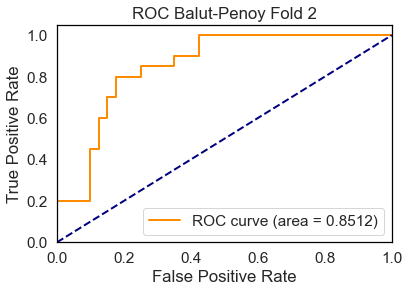

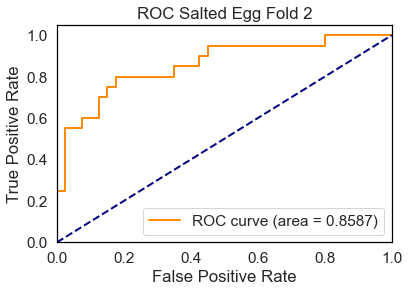

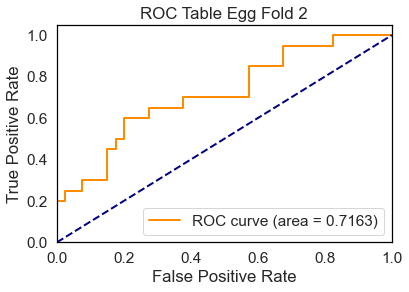

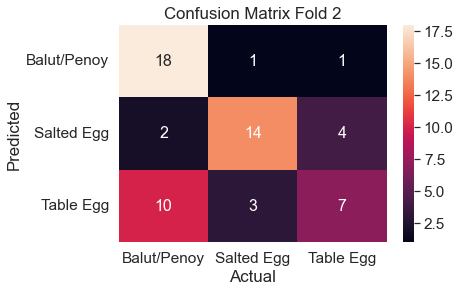


fold 3 metrics:
Accuracy: 0.633333
Precision: 0.669753
Recall: 0.633333
F1 score: 0.618044


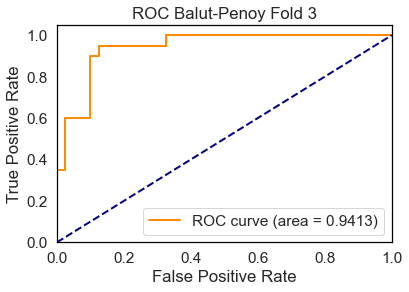

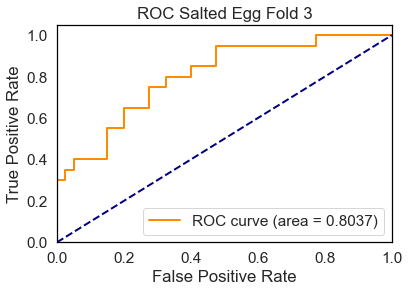

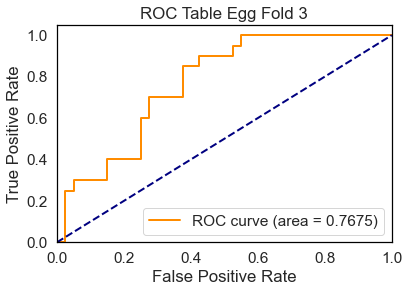

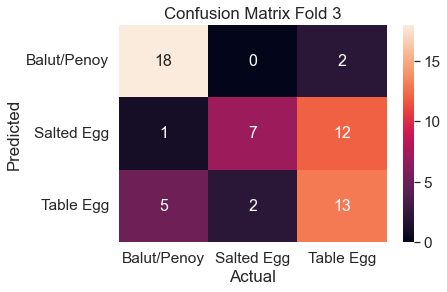


fold 4 metrics:
Accuracy: 0.633333
Precision: 0.646667
Recall: 0.633333
F1 score: 0.614815


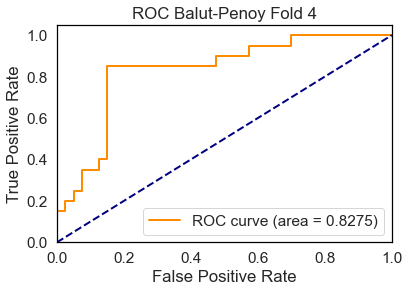

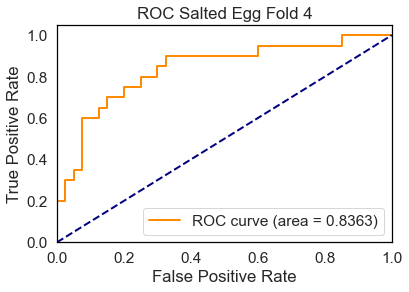

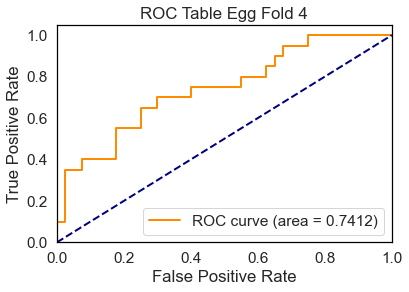

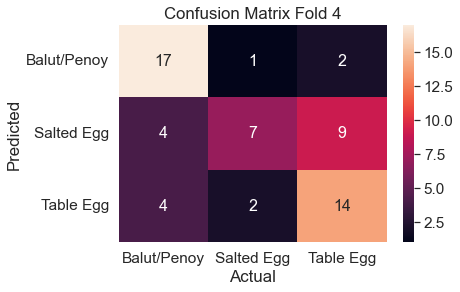


fold 5 metrics:
Accuracy: 0.583333
Precision: 0.585128
Recall: 0.583333
F1 score: 0.573256


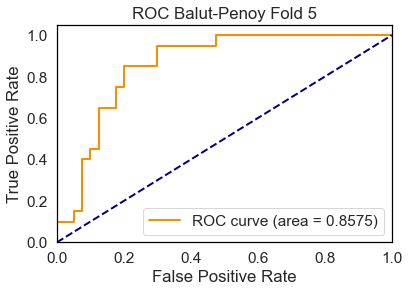

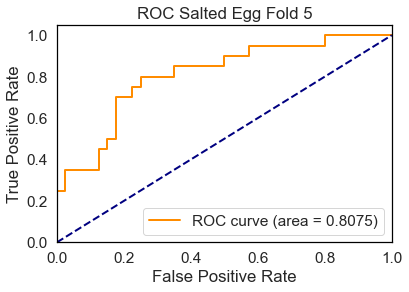

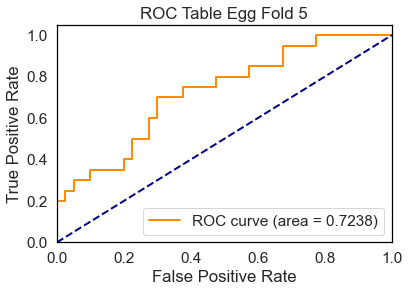

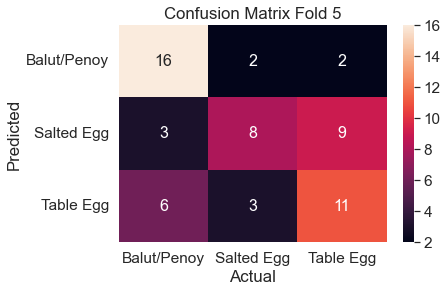

In [28]:
fold = 5
modelname = "saved_models_1"

#for fold number and average string
fold_ave = []

#for metrics values
total_acc = []
total_precision = []
total_recall = []
total_f1_score = []

#for confusion matrix sum of folds
matrix_sum = np.array([])

#for roc auc of folds per class
fpr_bp = []
tpr_bp = []

fpr_se = []
tpr_se = []

fpr_te = []
tpr_te = []

fpr_total = []
tpr_total = []

#for validating misclassified images
yhat_classes_total = []

for fold_num in range(fold):
    
    full_model = model()
    
    #load the weights of bet model
    model_dir = gen_dir + "/"+modelname+"/model_"+str(fold_num+1)+".h5"
    full_model.load_weights(model_dir)

    test_set = directory + "/ToBeUsed/test_set"

    testX = []

    for img_path in X_test['filename']:
        img = im.load_img(img_path, target_size=(224,224))
        x = im.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x.reshape(224,224,3)
        testX.append(x)

    testX = np.array(testX)    

    # predict probabilities for test set, y_test
    yhat_probs = full_model.predict(testX, verbose=0)

    # predict crisp classes for test set
    yhat_classes = yhat_probs.argmax(axis=-1)
    
    yhat_classes_total.append(yhat_classes)
    
    print("fold "+str(fold_num+1) +" metrics:")
    total_acc, total_precision, total_recall, total_f1_score, matrix_sum, fpr_total, tpr_total  = evaluate(yhat_probs,
                                                                                                           yhat_classes,
                                                                                                           total_acc,
                                                                                                           total_precision,
                                                                                                           total_recall,
                                                                                                           total_f1_score,
                                                                                                           matrix_sum,
                                                                                                           fold_num,
                                                                                                           fpr_total,
                                                                                                           tpr_total)
    
    fold_ave.append(str(fold_num+1))
    
    print('')


In [29]:
#Metrics
#-------------------------------------------------------------------------------------------------------------
fold_ave.append("Ave:")
total_acc.append(np.mean(total_acc))
total_precision.append(np.mean(total_precision))
total_recall.append(np.mean(total_recall))
total_f1_score.append(np.mean(total_recall))
    
df_eval = pd.DataFrame(data = list(zip(fold_ave,
                                       total_acc,
                                       total_precision,
                                       total_recall,
                                       total_f1_score)), columns=["Fold",
                                                                  "Accuracy",
                                                                  "Precision",
                                                                  "Recall",
                                                                  "F1 Score"])

#set fold_ave as the index
df_eval.set_index("Fold",inplace=True)

df_eval
#-------------------------------------------------------------------------------------------------------------

,Accuracy,Precision,Recall,F1 Score
Fold,,,,
1,0.616667,0.613757,0.616667,0.614463
2,0.650000,0.653704,0.650000,0.631447
3,0.633333,0.669753,0.633333,0.618044
4,0.633333,0.646667,0.633333,0.614815
5,0.583333,0.585128,0.583333,0.573256
Ave:,0.623333,0.633802,0.623333,0.623333


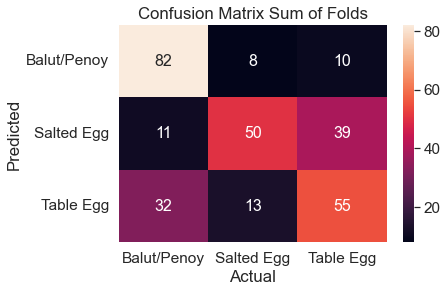

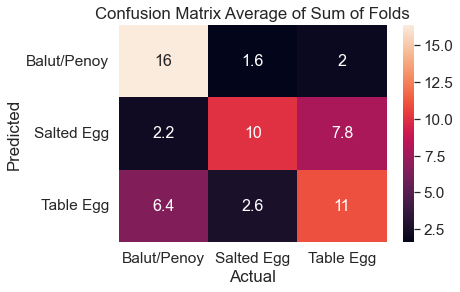

In [30]:
#Confusion Matrix
#-------------------------------------------------------------------------------------------------------------
#confusion matrix sum of folds
matrix_sum = np.array(matrix_sum)

df_cm = pd.DataFrame(matrix_sum, range(matrix_sum.shape[0]), range(matrix_sum.shape[1]))
df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                     index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})

# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix Sum of Folds")
plt.show()

#confusion matrix ave of sum of folds
matrix_ave = [[matrix_sum[i][j]/fold 
               for j in range(len(matrix_sum[0]))] 
              for i in range(len(matrix_sum))]

matrix_ave = np.array(matrix_ave)

df_cm = pd.DataFrame(matrix_ave, range(matrix_ave.shape[0]), range(matrix_ave.shape[1]))
df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                     index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix Average of Sum of Folds")
plt.show()
#-------------------------------------------------------------------------------------------------------------

C:\Users\user\AppData\Local\Temp/ipykernel_12240/224870489.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fpr_total = np.array(fpr_total)
C:\Users\user\AppData\Local\Temp/ipykernel_12240/224870489.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tpr_total = np.array(tpr_total)
C:\Users\user\AppData\Local\Temp/ipykernel_12240/224870489.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


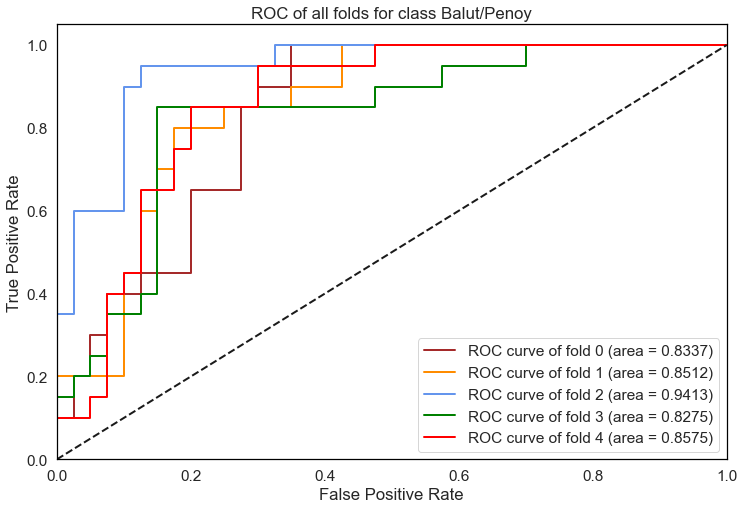

C:\Users\user\AppData\Local\Temp/ipykernel_12240/224870489.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


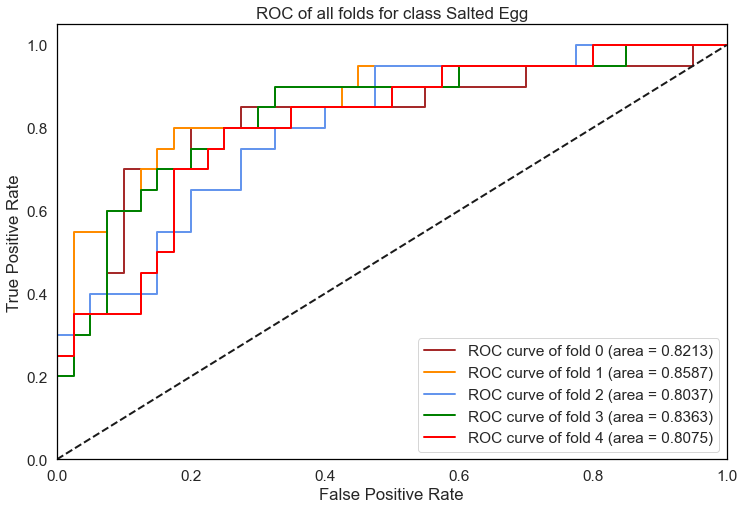

C:\Users\user\AppData\Local\Temp/ipykernel_12240/224870489.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


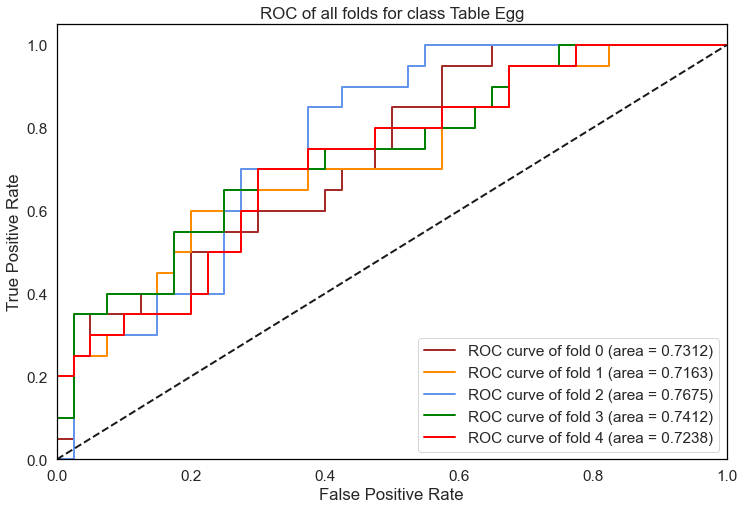

In [31]:
#ROC AUC
#-------------------------------------------------------------------------------------------------------------
fpr_total = np.array(fpr_total)
tpr_total = np.array(tpr_total)

#print("fpr_total")
#print(fpr_total)
#print("\ntpr_total")
#print(tpr_total)

classes = ["Balut/Penoy","Salted Egg","Table Egg"]

for x in range(len(fpr_total)):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(fold):
        fpr[i] = fpr_total[x][i]
        tpr[i] = tpr_total[x][i]
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(fold)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(fold):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= fold
   
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25

    # Plot all ROC curves
    plt.figure(figsize=(12, 8))
    lw = 2
   
    colors = cycle(['brown', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(fold), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of fold {0} (area = {1:0.4f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of all folds for class ' + classes[x])
    plt.legend(loc="lower right")
    plt.show()
#-------------------------------------------------------------------------------------------------------------

## Validating Misclassified Images

We will check whether or not the predicted classes of the images match with the true classes that they have. We will display the correct and incorrect predictions.

In [32]:
for yhat_classes in yhat_classes_total:
    print(yhat_classes.shape, yt.shape)

(60,) (60,)
(60,) (60,)
(60,) (60,)
(60,) (60,)
(60,) (60,)


We will get the images from the directories stored under the filename column.

In [33]:
testX2 = []

for img_path in X_test['filename']:
    img = cv2.imread(img_path)
    testX2.append(img)

testX2 = np.array(testX2)

### Correct predictions

Fold 1
Found 37 correct labels
11


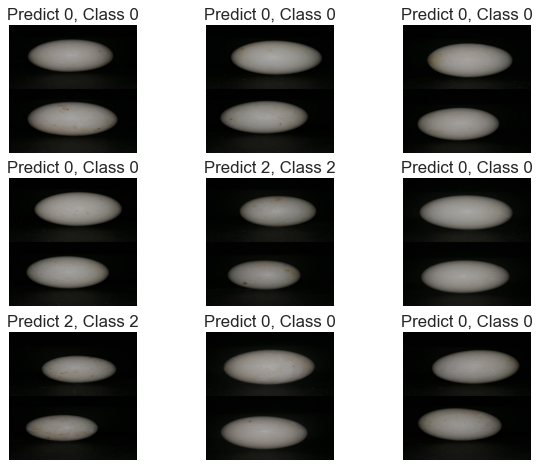

Fold 2
Found 39 correct labels
10


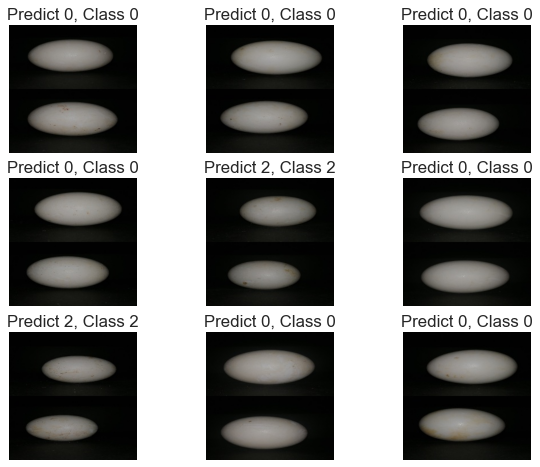

Fold 3
Found 38 correct labels
8


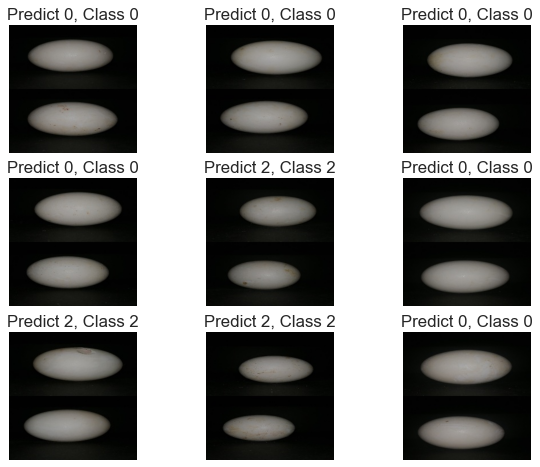

Fold 4
Found 38 correct labels
9


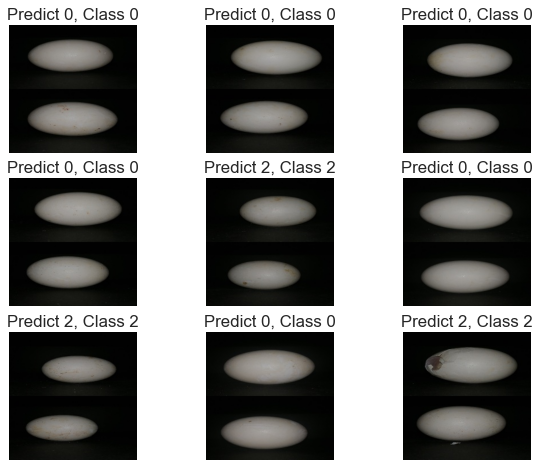

Fold 5
Found 35 correct labels
10


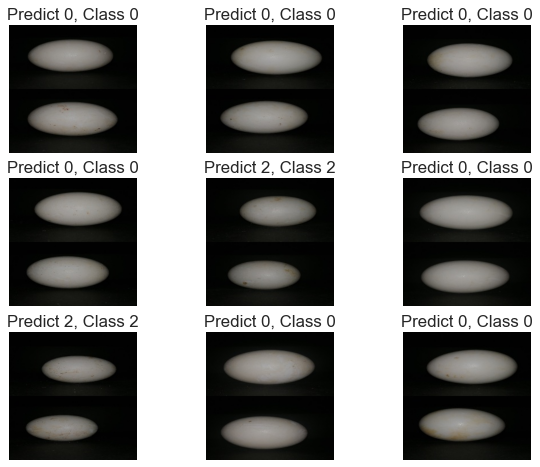

In [79]:
for x in range(len(yhat_classes_total)):
    print("Fold " + str(x+1))
    
    correct = np.where(yhat_classes_total[x]==yt)[0]

    print ("Found %d correct labels" % len(correct))

    print(correct[8])
    
    plt.figure(figsize=(10,8))
    for i, correct in enumerate(correct[:9]):
        plt.subplot(3,3,i+1)
        RGB_img = cv2.cvtColor(testX2[correct], cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
        plt.title("Predict {0}, Class {1}".format(str(yhat_classes_total[x][correct]),str(yt.values[correct])))
        plt.grid(False)
        plt.axis('off')
    
    plt.show()

### Incorrect predictions

Fold 1
Found 23 incorrect labels


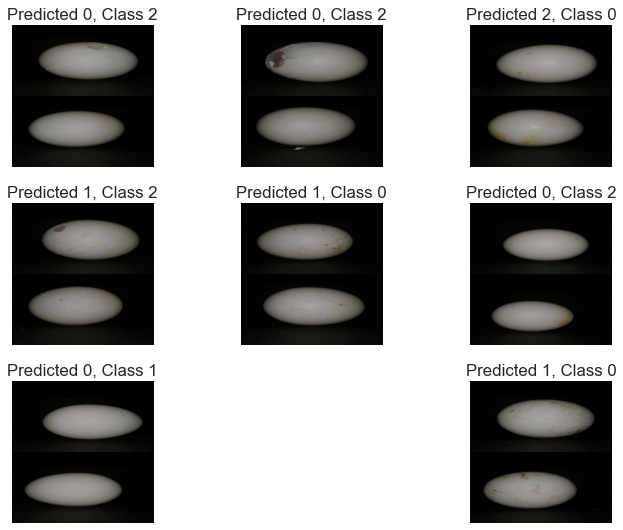

Fold 2
Found 21 incorrect labels


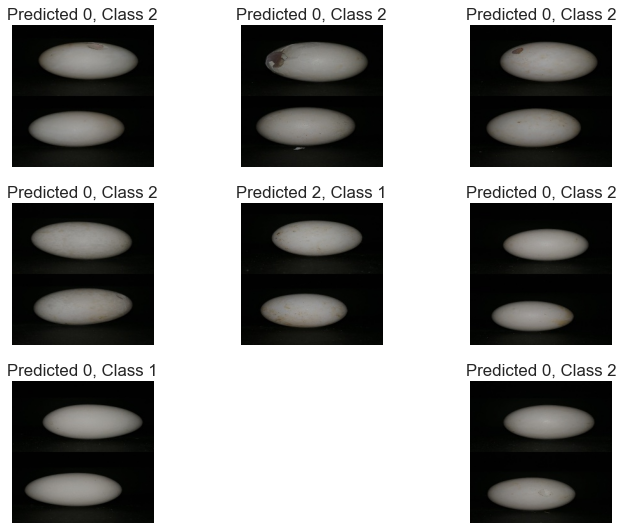

Fold 3
Found 22 incorrect labels


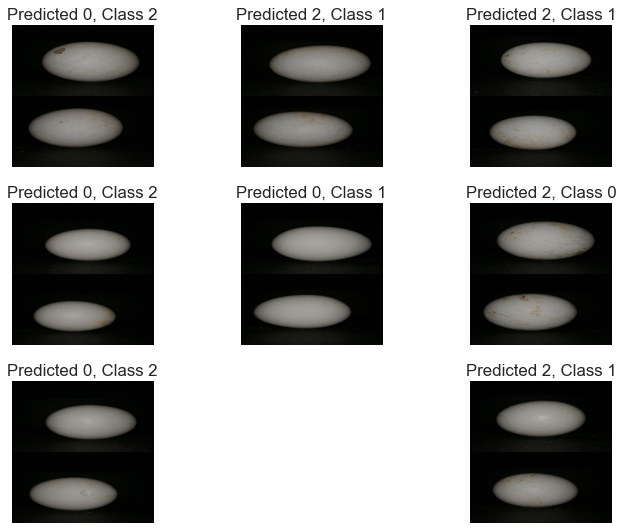

Fold 4
Found 22 incorrect labels


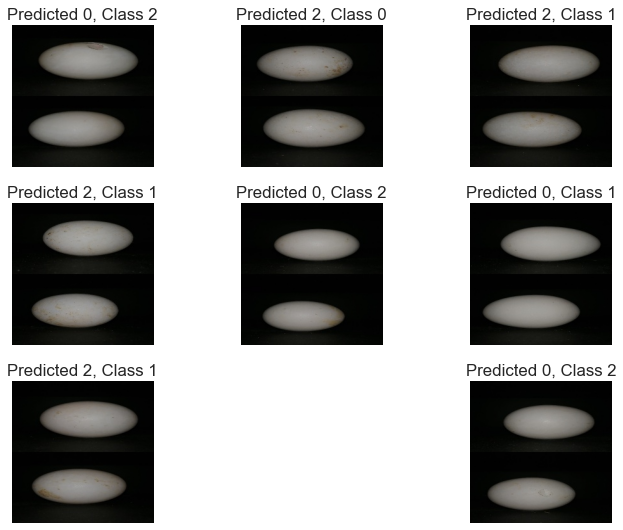

Fold 5
Found 25 incorrect labels


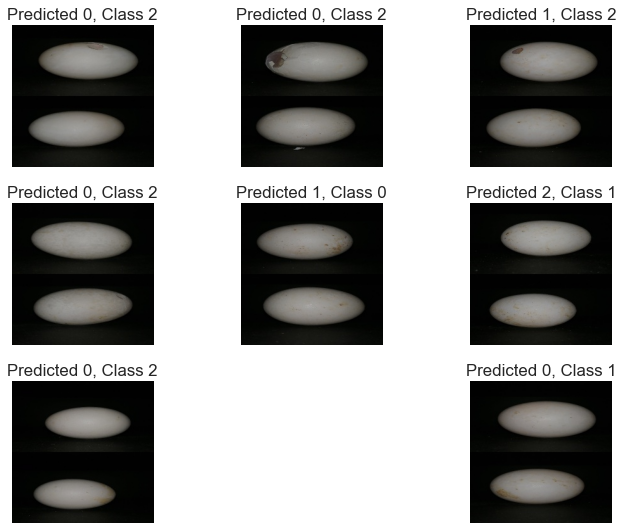

In [76]:
for x in range(len(yhat_classes_total)):
    print("Fold " + str(x+1))
    
    incorrect = np.where(yhat_classes_total[x]!=yt)[0]
    
    print ("Found %d incorrect labels" % len(incorrect))
    
    plt.figure(figsize=(10,8))
    for i, incorrect in enumerate(incorrect[:9]):
        plt.subplot(3,3,i+1)
        RGB_img = cv2.cvtColor(testX2[incorrect], cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
        plt.title("Predicted {0}, Class {1}".format(str(yhat_classes_total[x][incorrect]), str(yt.values[incorrect])))
        plt.grid(False)
        plt.axis('off')
    
    plt.show()